## The aim of this notebook is to select the best model using the classification report and ROC AUC score. 

* I will first conduct some feature engineering and scaling;

* Then comparing logistic regression, XGBClassifier and RandomForest, I will compare the accuracy results of two data sets where one has all the transformed features and the other only has features where the absolute correlation to the target variable is greater than 0.2

* I will then choose the best pair and apply hyper parameter tuning to the winning model to check for any improvement in the accuracy.

* I will then apply that model to the test set and check for overfitting. 

* If there is are signs of overfitting, I will check the accuracy of competing models against the test set. I am using this approach because it saves time. 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier as xgc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

%matplotlib inline


In [2]:
#reading source file
df = pd.read_csv(r"../cleaned_data/cleaned_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8476 entries, 0 to 8475
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    8476 non-null   float64
 1   RoomService            8476 non-null   float64
 2   FoodCourt              8476 non-null   float64
 3   ShoppingMall           8476 non-null   float64
 4   Spa                    8476 non-null   float64
 5   VRDeck                 8476 non-null   float64
 6   HomePlanet             8476 non-null   object 
 7   Destination            8476 non-null   object 
 8   VIP                    8476 non-null   bool   
 9   CryoSleep              8476 non-null   bool   
 10  Transported            8476 non-null   bool   
 11  cabin_group            8476 non-null   object 
 12  cabin_number           8476 non-null   int64  
 13  cabin_side             8476 non-null   object 
 14  passenger_group_size   8476 non-null   int64  
 15  Room

In [4]:
#spot check
df.tail()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,Transported,cabin_group,cabin_number,cabin_side,passenger_group_size,RoomService_customer,FoodCourt_customer,ShoppingMall_customer,Spa_customer,VRDeck_customer
8471,41.0,0.0,6819.0,0.0,1643.0,74.0,Europa,55 Cancri e,True,False,False,A,98,P,1,False,True,False,True,True
8472,18.0,0.0,0.0,0.0,0.0,0.0,Earth,PSO J318.5-22,False,True,False,G,1499,S,1,False,False,False,False,False
8473,26.0,0.0,0.0,1872.0,1.0,0.0,Earth,TRAPPIST-1e,False,False,True,G,1500,S,1,False,False,True,True,False
8474,32.0,0.0,1049.0,0.0,353.0,3235.0,Europa,55 Cancri e,False,False,False,E,608,S,2,False,True,False,True,True
8475,44.0,126.0,4688.0,0.0,0.0,12.0,Europa,TRAPPIST-1e,False,False,True,E,608,S,2,True,True,False,False,True


Plotting Heatmap of correlation

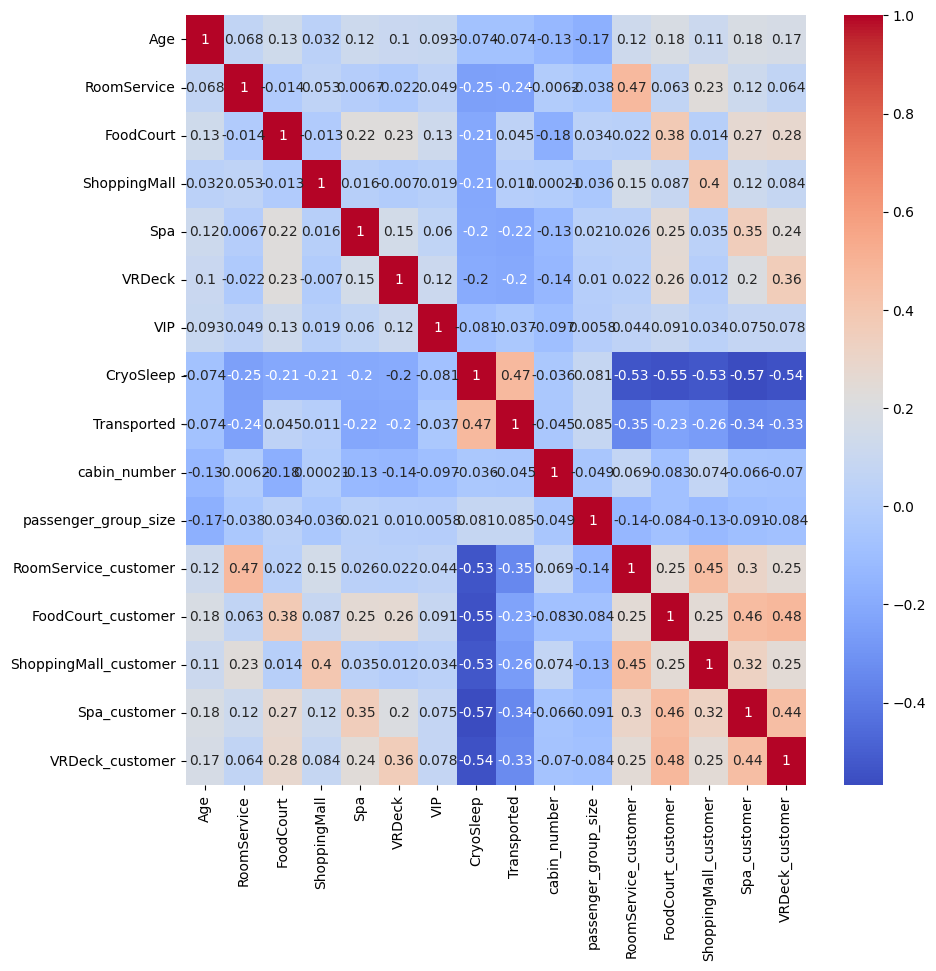

In [5]:

fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr(numeric_only=True)

sns.heatmap(
corr,
annot=True,
cmap='coolwarm'
)
plt.show()

Heatmap with a focus on only the target variable - Transported

<Axes: >

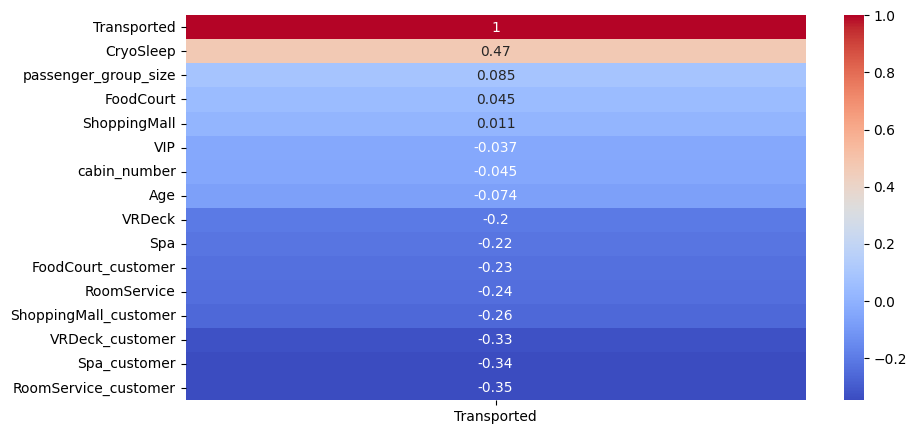

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
corr = df.corr(numeric_only=True)

sns.heatmap(
    corr[['Transported']].sort_values(by='Transported', ascending=False),
    annot=True,
    cmap='coolwarm'
)

We see some good correlations in the data; both positive and negative. 

We also notice that the feature engineering implemented for columns such as FoodCourt_customer (-0.23) is doing well compared to original columns such as FoodCourt (0.045)

I will split the data into training and test sets, then I will conduct feature scaling before checking the correlations again. 

In [7]:
x = df.drop('Transported', axis=1)
y = df[['Transported']]

In [8]:
x.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,cabin_group,cabin_number,cabin_side,passenger_group_size,RoomService_customer,FoodCourt_customer,ShoppingMall_customer,Spa_customer,VRDeck_customer
0,39.0,0.0,0.0,0.0,0.0,0.0,Europa,TRAPPIST-1e,False,False,B,0,P,1,False,False,False,False,False
1,24.0,109.0,9.0,25.0,549.0,44.0,Earth,TRAPPIST-1e,False,False,F,0,S,1,True,True,True,True,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,TRAPPIST-1e,True,False,A,0,S,2,True,True,False,True,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,Europa,TRAPPIST-1e,False,False,A,0,S,2,False,True,True,True,True
4,16.0,303.0,70.0,151.0,565.0,2.0,Earth,TRAPPIST-1e,False,False,F,1,S,1,True,True,True,True,True


In [9]:
y.head()

,Transported
0,False
1,True
2,False
3,False
4,True


Splitting the data into Train and Test sets

In [10]:
X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=12, stratify=y)

In [11]:
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,cabin_group,cabin_number,cabin_side,passenger_group_size,RoomService_customer,FoodCourt_customer,ShoppingMall_customer,Spa_customer,VRDeck_customer
7432,18.0,0.0,17.0,5.0,0.0,712.0,Earth,TRAPPIST-1e,False,False,F,1558,S,1,False,True,True,False,True
6695,27.0,0.0,1.0,12.0,0.0,779.0,Earth,TRAPPIST-1e,False,False,E,467,P,2,False,True,True,False,True
3594,29.0,3478.0,11153.0,15.0,203.0,15.0,Europa,TRAPPIST-1e,False,False,C,143,S,1,True,True,True,True,True
763,4.0,0.0,0.0,0.0,0.0,0.0,Earth,55 Cancri e,False,True,G,123,S,2,False,False,False,False,False
1997,24.0,0.0,421.0,0.0,207.0,63.0,Earth,55 Cancri e,False,False,F,438,P,1,False,True,False,True,True


In [12]:
X_train.shape

(6780, 19)

In [13]:
y_train.shape

(6780, 1)

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 7432 to 3120
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    6780 non-null   float64
 1   RoomService            6780 non-null   float64
 2   FoodCourt              6780 non-null   float64
 3   ShoppingMall           6780 non-null   float64
 4   Spa                    6780 non-null   float64
 5   VRDeck                 6780 non-null   float64
 6   HomePlanet             6780 non-null   object 
 7   Destination            6780 non-null   object 
 8   VIP                    6780 non-null   bool   
 9   CryoSleep              6780 non-null   bool   
 10  cabin_group            6780 non-null   object 
 11  cabin_number           6780 non-null   int64  
 12  cabin_side             6780 non-null   object 
 13  passenger_group_size   6780 non-null   int64  
 14  RoomService_customer   6780 non-null   bool   
 15  FoodCo

Categorising columns for the pipeline

In [15]:
num_cols = []
one_hot = []

for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        num_cols.append(col)
    elif X_train[col].dtype == 'int64':
        num_cols.append(col)
    else:
        one_hot.append(col)

print('*' * 62)
print("num_cols")
print(num_cols)
print("")
print('*' * 62)
print("one_hot")
print(one_hot)

**************************************************************
num_cols
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'cabin_number', 'passenger_group_size']

**************************************************************
one_hot
['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'cabin_group', 'cabin_side', 'RoomService_customer', 'FoodCourt_customer', 'ShoppingMall_customer', 'Spa_customer', 'VRDeck_customer']


Building pipelines

In [16]:
num_pipeline = Pipeline(
    steps=[('scaler', StandardScaler())]
)

one_hot_pipeline = Pipeline(
    steps=[('one_hot', OneHotEncoder(handle_unknown='ignore'))]
)

In [17]:
processor_model = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('one_hot', one_hot_pipeline, one_hot)
])

Processing the X_train data set

In [18]:
X_train_processed = processor_model.fit_transform(X_train)

X_features = processor_model.get_feature_names_out()

In [19]:
X_train_processed

array([[-0.75447164, -0.33221318, -0.2753617 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.13075382, -0.33221318, -0.28588426, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.00785014,  4.7638227 ,  7.04834616, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.47726372,  1.15938099, -0.22077587, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.35436003, -0.33221318, -0.28654192, ...,  0.        ,
         1.        ,  0.        ],
       [-0.96237757,  0.18061389, -0.28654192, ...,  1.        ,
         1.        ,  0.        ]], shape=(6780, 40))

In [20]:
X_features

array(['num__Age', 'num__RoomService', 'num__FoodCourt',
       'num__ShoppingMall', 'num__Spa', 'num__VRDeck',
       'num__cabin_number', 'num__passenger_group_size',
       'one_hot__HomePlanet_Earth', 'one_hot__HomePlanet_Europa',
       'one_hot__HomePlanet_Mars', 'one_hot__HomePlanet_unknown',
       'one_hot__Destination_55 Cancri e',
       'one_hot__Destination_PSO J318.5-22',
       'one_hot__Destination_TRAPPIST-1e', 'one_hot__Destination_unknown',
       'one_hot__VIP_False', 'one_hot__VIP_True',
       'one_hot__CryoSleep_False', 'one_hot__CryoSleep_True',
       'one_hot__cabin_group_A', 'one_hot__cabin_group_B',
       'one_hot__cabin_group_C', 'one_hot__cabin_group_D',
       'one_hot__cabin_group_E', 'one_hot__cabin_group_F',
       'one_hot__cabin_group_G', 'one_hot__cabin_group_T',
       'one_hot__cabin_side_P', 'one_hot__cabin_side_S',
       'one_hot__RoomService_customer_False',
       'one_hot__RoomService_customer_True',
       'one_hot__FoodCourt_customer_Fals

Creating a dataframe of the processed X_train data set

In [21]:
X_train_processed_df = pd.DataFrame(X_train_processed, columns=X_features, index=X_train.index)

In [22]:
X_train_processed_df

,num__Age,num__RoomService,num__FoodCourt,num__ShoppingMall,num__Spa,num__VRDeck,num__cabin_number,num__passenger_group_size,one_hot__HomePlanet_Earth,one_hot__HomePlanet_Europa,...,one_hot__RoomService_customer_False,one_hot__RoomService_customer_True,one_hot__FoodCourt_customer_False,one_hot__FoodCourt_customer_True,one_hot__ShoppingMall_customer_False,one_hot__ShoppingMall_customer_True,one_hot__Spa_customer_False,one_hot__Spa_customer_True,one_hot__VRDeck_customer_False,one_hot__VRDeck_customer_True
7432,-0.754472,-0.332213,-0.275362,-0.290058,-0.265089,0.380941,1.887261,-0.645587,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
6695,-0.130754,-0.332213,-0.285884,-0.277672,-0.265089,0.441782,-0.273934,-0.011870,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3594,0.007850,4.763823,7.048346,-0.272363,-0.092470,-0.251989,-0.915756,-0.645587,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
763,-1.724699,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,-0.955374,-0.011870,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1997,-0.338660,-0.332213,-0.009667,-0.298906,-0.089069,-0.208402,-0.331381,-0.645587,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,-0.130754,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,-0.470046,-0.645587,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2767,0.562266,1.259016,-0.286542,-0.298906,-0.230225,-0.265611,0.062824,-0.645587,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1443,-0.477264,1.159381,-0.220776,-0.298906,-0.257436,-0.265611,0.254974,-0.011870,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3578,0.354360,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,0.072729,-0.645587,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [23]:
y_train

,Transported
7432,True
6695,False
3594,True
763,True
1997,False
...,...
5157,True
2767,False
1443,False
3578,True


In [24]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 7432 to 3120
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Transported  6780 non-null   bool 
dtypes: bool(1)
memory usage: 59.6 KB


Creating another dataframe called X_processed_df_full which concatenates the X_processed_df with the y_train dataframe. This is done to assess the correlation to the target variable and also see wich features have an absolute correlation >= 0.2

In [25]:
X_processed_df_full = pd.concat([X_train_processed_df, y_train], axis=1)

In [26]:
X_processed_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6780 entries, 7432 to 3120
Data columns (total 41 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   num__Age                              6780 non-null   float64
 1   num__RoomService                      6780 non-null   float64
 2   num__FoodCourt                        6780 non-null   float64
 3   num__ShoppingMall                     6780 non-null   float64
 4   num__Spa                              6780 non-null   float64
 5   num__VRDeck                           6780 non-null   float64
 6   num__cabin_number                     6780 non-null   float64
 7   num__passenger_group_size             6780 non-null   float64
 8   one_hot__HomePlanet_Earth             6780 non-null   float64
 9   one_hot__HomePlanet_Europa            6780 non-null   float64
 10  one_hot__HomePlanet_Mars              6780 non-null   float64
 11  one_hot__HomePlanet

In [27]:
X_processed_df_full

,num__Age,num__RoomService,num__FoodCourt,num__ShoppingMall,num__Spa,num__VRDeck,num__cabin_number,num__passenger_group_size,one_hot__HomePlanet_Earth,one_hot__HomePlanet_Europa,...,one_hot__RoomService_customer_True,one_hot__FoodCourt_customer_False,one_hot__FoodCourt_customer_True,one_hot__ShoppingMall_customer_False,one_hot__ShoppingMall_customer_True,one_hot__Spa_customer_False,one_hot__Spa_customer_True,one_hot__VRDeck_customer_False,one_hot__VRDeck_customer_True,Transported
7432,-0.754472,-0.332213,-0.275362,-0.290058,-0.265089,0.380941,1.887261,-0.645587,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,True
6695,-0.130754,-0.332213,-0.285884,-0.277672,-0.265089,0.441782,-0.273934,-0.011870,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,False
3594,0.007850,4.763823,7.048346,-0.272363,-0.092470,-0.251989,-0.915756,-0.645587,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,True
763,-1.724699,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,-0.955374,-0.011870,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True
1997,-0.338660,-0.332213,-0.009667,-0.298906,-0.089069,-0.208402,-0.331381,-0.645587,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157,-0.130754,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,-0.470046,-0.645587,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True
2767,0.562266,1.259016,-0.286542,-0.298906,-0.230225,-0.265611,0.062824,-0.645587,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,False
1443,-0.477264,1.159381,-0.220776,-0.298906,-0.257436,-0.265611,0.254974,-0.011870,1.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,False
3578,0.354360,-0.332213,-0.286542,-0.298906,-0.265089,-0.265611,0.072729,-0.645587,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,True


Plotting Correlation Heatmap for "Transported"

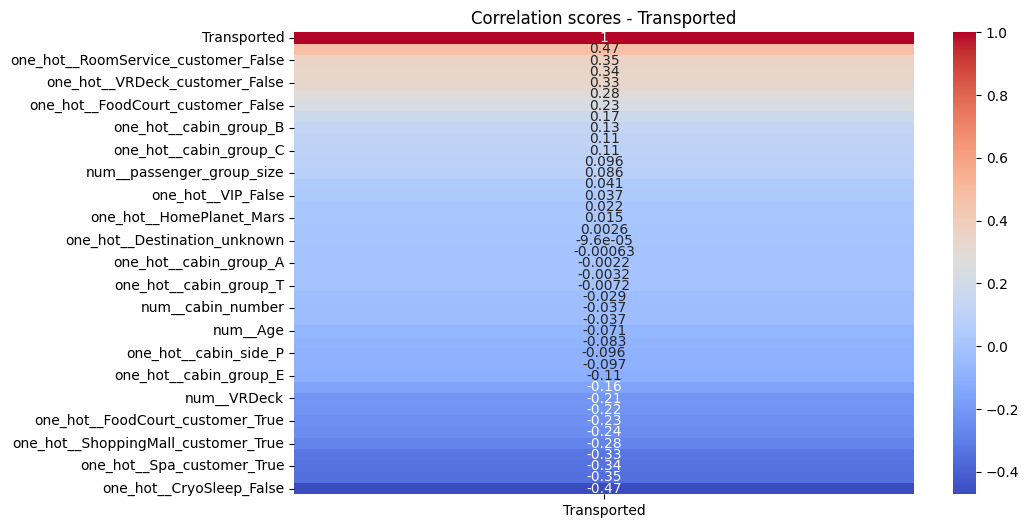

In [28]:
corr2 = X_processed_df_full.corr()

fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(corr2[['Transported']].sort_values(by='Transported', ascending=False), annot=True, cmap='coolwarm'

)
plt.title("Correlation scores - Transported")
plt.show()



I will now experiment to see if using columns where the absolute correlation to Transported is >= 0.2 will reduce noise and improve accuracy

In [29]:
corr2_df = (corr2[['Transported']].
                 sort_values(by='Transported', ascending=False)
                 .reset_index()
                 .rename(columns={'index':'columns', 'Transported': 'corr'}))

In [30]:
corr2_df

,columns,corr
0,Transported,1.000000
1,one_hot__CryoSleep_True,0.471495
2,one_hot__RoomService_customer_False,0.351583
3,one_hot__Spa_customer_False,0.344627
4,one_hot__VRDeck_customer_False,0.330803
5,one_hot__ShoppingMall_customer_False,0.276923
6,one_hot__FoodCourt_customer_False,0.233050
7,one_hot__HomePlanet_Europa,0.174070
8,one_hot__cabin_group_B,0.134615
9,one_hot__Destination_55 Cancri e,0.110021


Generating a list of high correlation columns. That is columsn where the absolute correlation score is >= 0.2

In [31]:
high_corr_columns = corr2_df[abs(corr2_df["corr"]) >= 0.2]['columns'].values.tolist()

high_corr_columns

['Transported',
 'one_hot__CryoSleep_True',
 'one_hot__RoomService_customer_False',
 'one_hot__Spa_customer_False',
 'one_hot__VRDeck_customer_False',
 'one_hot__ShoppingMall_customer_False',
 'one_hot__FoodCourt_customer_False',
 'num__VRDeck',
 'num__Spa',
 'one_hot__FoodCourt_customer_True',
 'num__RoomService',
 'one_hot__ShoppingMall_customer_True',
 'one_hot__VRDeck_customer_True',
 'one_hot__Spa_customer_True',
 'one_hot__RoomService_customer_True',
 'one_hot__CryoSleep_False']

In [32]:
high_corr_columns = [x for x in high_corr_columns if x != "Transported"] # removing Transported from the list
high_corr_columns


['one_hot__CryoSleep_True',
 'one_hot__RoomService_customer_False',
 'one_hot__Spa_customer_False',
 'one_hot__VRDeck_customer_False',
 'one_hot__ShoppingMall_customer_False',
 'one_hot__FoodCourt_customer_False',
 'num__VRDeck',
 'num__Spa',
 'one_hot__FoodCourt_customer_True',
 'num__RoomService',
 'one_hot__ShoppingMall_customer_True',
 'one_hot__VRDeck_customer_True',
 'one_hot__Spa_customer_True',
 'one_hot__RoomService_customer_True',
 'one_hot__CryoSleep_False']

In [33]:
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,VIP,CryoSleep,cabin_group,cabin_number,cabin_side,passenger_group_size,RoomService_customer,FoodCourt_customer,ShoppingMall_customer,Spa_customer,VRDeck_customer
7432,18.0,0.0,17.0,5.0,0.0,712.0,Earth,TRAPPIST-1e,False,False,F,1558,S,1,False,True,True,False,True
6695,27.0,0.0,1.0,12.0,0.0,779.0,Earth,TRAPPIST-1e,False,False,E,467,P,2,False,True,True,False,True
3594,29.0,3478.0,11153.0,15.0,203.0,15.0,Europa,TRAPPIST-1e,False,False,C,143,S,1,True,True,True,True,True
763,4.0,0.0,0.0,0.0,0.0,0.0,Earth,55 Cancri e,False,True,G,123,S,2,False,False,False,False,False
1997,24.0,0.0,421.0,0.0,207.0,63.0,Earth,55 Cancri e,False,False,F,438,P,1,False,True,False,True,True


Creating the X_train_processed_filtered_df which is the processed X_train data set but containing only the high correlatioin columns

In [34]:
X_train_processed_filtered_df = X_train_processed_df[high_corr_columns]

In [35]:
X_train_processed_filtered_df.head()

,one_hot__CryoSleep_True,one_hot__RoomService_customer_False,one_hot__Spa_customer_False,one_hot__VRDeck_customer_False,one_hot__ShoppingMall_customer_False,one_hot__FoodCourt_customer_False,num__VRDeck,num__Spa,one_hot__FoodCourt_customer_True,num__RoomService,one_hot__ShoppingMall_customer_True,one_hot__VRDeck_customer_True,one_hot__Spa_customer_True,one_hot__RoomService_customer_True,one_hot__CryoSleep_False
7432,0.0,1.0,1.0,0.0,0.0,0.0,0.380941,-0.265089,1.0,-0.332213,1.0,1.0,0.0,0.0,1.0
6695,0.0,1.0,1.0,0.0,0.0,0.0,0.441782,-0.265089,1.0,-0.332213,1.0,1.0,0.0,0.0,1.0
3594,0.0,0.0,0.0,0.0,0.0,0.0,-0.251989,-0.092470,1.0,4.763823,1.0,1.0,1.0,1.0,1.0
763,1.0,1.0,1.0,1.0,1.0,1.0,-0.265611,-0.265089,0.0,-0.332213,0.0,0.0,0.0,0.0,0.0
1997,0.0,1.0,0.0,0.0,1.0,0.0,-0.208402,-0.089069,1.0,-0.332213,0.0,1.0,1.0,0.0,1.0


#### Testing the Models: 
* XGBClassifier 
* Logistic Regression, 
* RandomForestClassifier

#### on each set of training data - X_train_processed_df and X_train_processed_filtered_df to see which one has the best accuracy 

* XGBClassifier on Filtered Processed Dataset

In [36]:

model = xgc()

In [37]:
model.fit(X_train_processed_filtered_df, y_train)

xgc_yhat = model.predict(X_train_processed_filtered_df)
xgc_yhat_proba = model.predict_proba(X_train_processed_filtered_df)[:, 1]

In [38]:
print(classification_report(y_train, xgc_yhat))
print("ROC AUC:", roc_auc_score(xgc_yhat, xgc_yhat_proba))

              precision    recall  f1-score   support

       False       0.88      0.76      0.81      3363
        True       0.79      0.90      0.84      3417

    accuracy                           0.83      6780
   macro avg       0.84      0.83      0.83      6780
weighted avg       0.84      0.83      0.83      6780

ROC AUC: 1.0


* XGBClassifier on Full Processed Dataset

In [39]:
model2 =xgc()
    

model2.fit(X_train_processed_df, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [40]:
xgc2_yhat = model2.predict(X_train_processed_df)
xgc2_yhat_proba = model2.predict_proba(X_train_processed_df)[:, 1]

In [41]:
print(classification_report(y_train, xgc2_yhat))
print("ROC AUC:", roc_auc_score(xgc_yhat, xgc2_yhat_proba))

              precision    recall  f1-score   support

       False       0.94      0.93      0.94      3363
        True       0.93      0.94      0.94      3417

    accuracy                           0.94      6780
   macro avg       0.94      0.94      0.94      6780
weighted avg       0.94      0.94      0.94      6780

ROC AUC: 0.9498456660178946


Looking at the f1-score score for both approaches, keeping all the transformed columns does not add noise to the model and actually improves the  score of the XGBClassifier although there is a slight drop in the ROC AUC score

* LogisticRegression on Filtered Processed Dataset

In [42]:
model_lr = LogisticRegression()

model_lr.fit(X_train_processed_filtered_df, y_train)

/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [43]:
lr_yhat = model_lr.predict(X_train_processed_filtered_df)
lr_yhat_proba = model.predict_proba(X_train_processed_filtered_df)[:, 1]

In [44]:

print(classification_report(y_train, lr_yhat))
print("ROC AUC:", roc_auc_score(y_train, lr_yhat_proba))

              precision    recall  f1-score   support

       False       0.77      0.74      0.76      3363
        True       0.75      0.79      0.77      3417

    accuracy                           0.76      6780
   macro avg       0.76      0.76      0.76      6780
weighted avg       0.76      0.76      0.76      6780

ROC AUC: 0.8778395980775489


* LogisticRegression on Full Processed Dataset

In [45]:
model_lr2 = LogisticRegression()

model_lr2.fit(X_train_processed_df, y_train)

/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [46]:
lr2_yhat = model_lr2.predict(X_train_processed_df)
lr2_yhat_proba = model_lr2.predict_proba(X_train_processed_df)[:, 1]

In [47]:

print(classification_report(y_train, lr2_yhat))
print("ROC AUC:", roc_auc_score(y_train, lr2_yhat_proba))

              precision    recall  f1-score   support

       False       0.81      0.77      0.79      3363
        True       0.78      0.82      0.80      3417

    accuracy                           0.79      6780
   macro avg       0.80      0.79      0.79      6780
weighted avg       0.80      0.79      0.79      6780

ROC AUC: 0.881512963074641


Looking at the results, the full dataset is still better than the filtered. However, the logistic regression is not doing any better than the XGBClassifier

* RandomForestClassifier on Filtered Processed Dataset

In [48]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train_processed_filtered_df, y_train)

/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [49]:
rf_yhat = rf_model.predict(X_train_processed_filtered_df)
rf_yhat_proba = rf_model.predict_proba(X_train_processed_filtered_df)[:, 1]

In [50]:

print(classification_report(y_train, rf_yhat))
print("ROC AUC:", roc_auc_score(y_train, rf_yhat_proba))

              precision    recall  f1-score   support

       False       1.00      0.80      0.89      3363
        True       0.83      1.00      0.91      3417

    accuracy                           0.90      6780
   macro avg       0.91      0.90      0.90      6780
weighted avg       0.91      0.90      0.90      6780

ROC AUC: 0.9161725350264994


* LogisticRegression on Full Processed Dataset

In [51]:
rf2_model = RandomForestClassifier()

rf2_model.fit(X_train_processed_df, y_train)

/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [52]:
rf2_yhat = rf2_model.predict(X_train_processed_df)
rf2_yhat_proba = rf2_model.predict_proba(X_train_processed_df)[:, 1]

In [53]:
print(classification_report(y_train, rf2_yhat))
print("ROC AUC:", roc_auc_score(y_train, rf2_yhat_proba))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3363
        True       1.00      1.00      1.00      3417

    accuracy                           1.00      6780
   macro avg       1.00      1.00      1.00      6780
weighted avg       1.00      1.00      1.00      6780

ROC AUC: 0.9999956489090815


The same theory is true - the full dataset performs better and the RandomForestClassifier is the best performing model. Let's see how the models perform on the test data set

# Assessing the  models on the test set for overfitting

Processing the X_test data and using the full dataset since it is proven to give better results

In [54]:
X_test_processed = processor_model.transform(X_test)

X_test_features = processor_model.get_feature_names_out()

Creating a dataframe out of the X_test data

In [55]:
X_test_processed_df = pd.DataFrame(X_test_processed, columns=X_test_features, index=X_test.index)

#### * LogisticRegression

In [56]:
lr2_test_yhatmodel = model_lr2.predict(X_test_processed_df)
lr2_test_yhatmodel_proba = model_lr2.predict_proba(X_test_processed_df)[:,1]


In [57]:
print("Training")
print("*" * 62)
print(classification_report(y_train, lr2_yhat))
print("ROC AUC:", roc_auc_score(y_train, lr2_yhat_proba))
print("*" * 62)
print("")
print("Test")
print("*" * 62)
print(classification_report(y_test, lr2_test_yhatmodel))
print("ROC AUC:", roc_auc_score(y_test, lr2_test_yhatmodel_proba))
print("*" * 62)


Training
**************************************************************
              precision    recall  f1-score   support

       False       0.81      0.77      0.79      3363
        True       0.78      0.82      0.80      3417

    accuracy                           0.79      6780
   macro avg       0.80      0.79      0.79      6780
weighted avg       0.80      0.79      0.79      6780

ROC AUC: 0.881512963074641
**************************************************************

Test
**************************************************************
              precision    recall  f1-score   support

       False       0.82      0.77      0.79       841
        True       0.78      0.83      0.81       855

    accuracy                           0.80      1696
   macro avg       0.80      0.80      0.80      1696
weighted avg       0.80      0.80      0.80      1696

ROC AUC: 0.8823580949996871
**************************************************************


Even though the scores could be better. The model performs equally well on the test set. No signs of overfitting

### * XGBClassifier

In [58]:
xgc_test_yhat = model2.predict(X_test_processed_df)
xgc_test_yhat_proba = model2.predict_proba(X_test_processed_df)[:,1]

In [59]:
print("Training")
print("*" * 62)
print(classification_report(y_train, xgc2_yhat))
print("ROC AUC:", roc_auc_score(y_train, xgc2_yhat_proba))
print("*" * 62)
print("")
print("Test")
print("*" * 62)
print(classification_report(y_test, xgc_test_yhat))
print("ROC AUC:", roc_auc_score(y_test, xgc_test_yhat_proba))
print("*" * 62)

Training
**************************************************************
              precision    recall  f1-score   support

       False       0.94      0.93      0.94      3363
        True       0.93      0.94      0.94      3417

    accuracy                           0.94      6780
   macro avg       0.94      0.94      0.94      6780
weighted avg       0.94      0.94      0.94      6780

ROC AUC: 0.9868994743969193
**************************************************************

Test
**************************************************************
              precision    recall  f1-score   support

       False       0.79      0.81      0.80       841
        True       0.81      0.80      0.80       855

    accuracy                           0.80      1696
   macro avg       0.80      0.80      0.80      1696
weighted avg       0.80      0.80      0.80      1696

ROC AUC: 0.8933843725445203
**************************************************************


The XGBClassifier which had training scores showed just a significant drop in the test data and this does indicate overfitting

### * RandomForestClassifier 

In [60]:
rf2_test_yhat = rf2_model.predict(X_test_processed_df)
rf2_test_yhat_proba = rf2_model.predict_proba(X_test_processed_df)[:,1]

In [61]:
print("Training")
print("*" * 62)
print(classification_report(y_train, rf2_yhat))
print("ROC AUC:", roc_auc_score(y_train, rf2_yhat_proba))
print("*" * 62)
print("")
print("Test")
print("*" * 62)
print(classification_report(y_test, rf2_test_yhat))
print("ROC AUC:", roc_auc_score(y_test, rf2_test_yhat_proba))
print("*" * 62)

Training
**************************************************************
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3363
        True       1.00      1.00      1.00      3417

    accuracy                           1.00      6780
   macro avg       1.00      1.00      1.00      6780
weighted avg       1.00      1.00      1.00      6780

ROC AUC: 0.9999956489090815
**************************************************************

Test
**************************************************************
              precision    recall  f1-score   support

       False       0.78      0.82      0.80       841
        True       0.82      0.76      0.79       855

    accuracy                           0.79      1696
   macro avg       0.80      0.79      0.79      1696
weighted avg       0.80      0.79      0.79      1696

ROC AUC: 0.8757049182607729
**************************************************************


Although the RandomForestClassifier model showed great promise in the training data, it performed poorly on unseen data, indicating overfitting

#### Based on these findings, I will use tune the XGBClassifier and test for better results. 

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(xgc(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_processed_df, y_train)
best_model = grid_search.best_estimator_

In [63]:
xgb_bm_training_yhat = best_model.predict(X_train_processed_df)
xgb_bm_test_yhat = best_model.predict(X_test_processed_df)

xgb_bm_training_yhat_proba = best_model.predict_proba(X_train_processed_df)[:,1]
xgb_bm_test_yhat_proba = best_model.predict_proba(X_test_processed_df)[:,1]

In [64]:
print("Training")
print("*" * 62)
print(classification_report(y_train, xgb_bm_training_yhat))
print("ROC AUC:", roc_auc_score(y_train, xgb_bm_training_yhat_proba))
print("*" * 62)
print("")
print("Test")
print("*" * 62)
print(classification_report(y_test, xgb_bm_test_yhat))
print("ROC AUC:", roc_auc_score(y_test, xgb_bm_test_yhat_proba))
print("*" * 62)

Training
**************************************************************
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      3363
        True       0.85      0.86      0.86      3417

    accuracy                           0.86      6780
   macro avg       0.86      0.86      0.86      6780
weighted avg       0.86      0.86      0.86      6780

ROC AUC: 0.9427202811570525
**************************************************************

Test
**************************************************************
              precision    recall  f1-score   support

       False       0.81      0.80      0.80       841
        True       0.80      0.81      0.81       855

    accuracy                           0.80      1696
   macro avg       0.80      0.80      0.80      1696
weighted avg       0.80      0.80      0.80      1696

ROC AUC: 0.9023579559282671
**************************************************************


With in implementation of the XGBC tuninng, we see an neglible improvement in the training data but no change in the test data

In [65]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train_processed_df, y_train)

rf_best_model = grid_search.best_estimator_

/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rickyansong/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Projects/space_ship_titanic/.venv/lib/python3.11/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

In [66]:
rf_bm_training_yhat = rf_best_model.predict(X_train_processed_df)
rf_bm_test_yhat = rf_best_model.predict(X_test_processed_df)

rf_bm_training_yhat_proba = rf_best_model.predict_proba(X_train_processed_df)[:,1]
rf_bm_test_yhat_proba = rf_best_model.predict_proba(X_test_processed_df)[:,1]

In [67]:
print("Training")
print("*" * 62)
print(classification_report(y_train, rf_bm_training_yhat))
print("ROC AUC:", roc_auc_score(y_train, rf_bm_training_yhat_proba))
print("*" * 62)
print("")
print("Test")
print("*" * 62)
print(classification_report(y_test, rf_bm_test_yhat))
print("ROC AUC:", roc_auc_score(y_test, rf_bm_test_yhat_proba))
print("*" * 62)

Training
**************************************************************
              precision    recall  f1-score   support

       False       0.87      0.86      0.86      3363
        True       0.86      0.87      0.87      3417

    accuracy                           0.87      6780
   macro avg       0.87      0.87      0.87      6780
weighted avg       0.87      0.87      0.87      6780

ROC AUC: 0.9544969873481589
**************************************************************

Test
**************************************************************
              precision    recall  f1-score   support

       False       0.80      0.78      0.79       841
        True       0.79      0.81      0.80       855

    accuracy                           0.80      1696
   macro avg       0.80      0.80      0.80      1696
weighted avg       0.80      0.80      0.80      1696

ROC AUC: 0.8875106911154222
**************************************************************


After tunining the RandomForestClassifier it shows good scores in both training and test data without overfitting and performs better than the XGBClassifier

#### creating a dataframe of the features and their importance

In [68]:
rf_best_model.feature_importances_

array([0.05170098, 0.07328981, 0.06821012, 0.05198909, 0.08373114,
       0.06851404, 0.06474911, 0.017386  , 0.02756324, 0.02015965,
       0.00900835, 0.00091742, 0.00625083, 0.00337746, 0.00764664,
       0.00032136, 0.00041795, 0.00041243, 0.08757172, 0.07995464,
       0.00089959, 0.00461753, 0.00616842, 0.0017859 , 0.01262797,
       0.01411789, 0.01698249, 0.        , 0.01135529, 0.01066475,
       0.03080695, 0.03468872, 0.00763801, 0.00818486, 0.0091402 ,
       0.01051445, 0.02077546, 0.02343097, 0.02630135, 0.0261272 ])

In [69]:
rf_best_model.feature_names_in_

array(['num__Age', 'num__RoomService', 'num__FoodCourt',
       'num__ShoppingMall', 'num__Spa', 'num__VRDeck',
       'num__cabin_number', 'num__passenger_group_size',
       'one_hot__HomePlanet_Earth', 'one_hot__HomePlanet_Europa',
       'one_hot__HomePlanet_Mars', 'one_hot__HomePlanet_unknown',
       'one_hot__Destination_55 Cancri e',
       'one_hot__Destination_PSO J318.5-22',
       'one_hot__Destination_TRAPPIST-1e', 'one_hot__Destination_unknown',
       'one_hot__VIP_False', 'one_hot__VIP_True',
       'one_hot__CryoSleep_False', 'one_hot__CryoSleep_True',
       'one_hot__cabin_group_A', 'one_hot__cabin_group_B',
       'one_hot__cabin_group_C', 'one_hot__cabin_group_D',
       'one_hot__cabin_group_E', 'one_hot__cabin_group_F',
       'one_hot__cabin_group_G', 'one_hot__cabin_group_T',
       'one_hot__cabin_side_P', 'one_hot__cabin_side_S',
       'one_hot__RoomService_customer_False',
       'one_hot__RoomService_customer_True',
       'one_hot__FoodCourt_customer_Fals

In [70]:
importance_df = pd.DataFrame({
    "feature": rf_best_model.feature_names_in_,
    "importance": rf_best_model.feature_importances_
}).sort_values(by="importance", ascending=False)

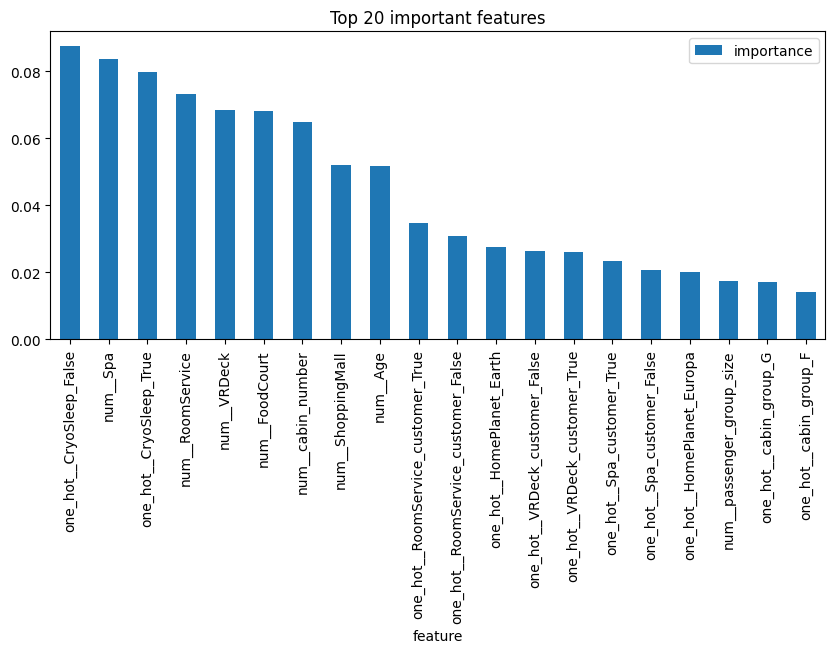

In [71]:
importance_df[:20].plot(
    kind='bar',
    x='feature',
    y='importance',
    figsize=(10, 4)
)
plt.title("Top 20 important features")
plt.show()

Saving model and artificacts

In [72]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs("../artifacts", exist_ok=True)

# Save the preprocessor
joblib.dump(processor_model, "../artifacts/preprocessor.joblib")



['../artifacts/preprocessor.joblib']

Saving best model

In [73]:
import pickle


# Create the directory if it doesn't exist
os.makedirs("../best_model", exist_ok=True)

# Save the model correctly
with open("../best_model/rf_best_model.pkl", "wb") as f:
    pickle.dump(rf_best_model, f)